# Purpose:

This notebook is going to be a way for me to model the effects that genotypic size differences have on the sampling of cells from a population of individuals. This stems from the observation that larger individuals have a bias to being sampled from my pool of cells given that they are contributing more cells to the pool. This means that even if I cluster all my cells correctly there is a distinct possibility that I won't remove the effects of size bias. I am therefore going to model this sampling process and try to figure out by which parameters I can get rid of the size bias.

# Model:

Now I am going to define my model for the cell sampling process. The sampling process is essentially a Multinomial process defined as, $MultiN \sim (\pi_i)$. The probability of sampling a given cell from an individual is equivalent to the $\pi_i$ of that individual. This is assuming that the number of cells contributed by an individual is so large that it is essentially sampling with replacement.

In order to correctly cluster all individuals we must construct an experiment such that we sample ALL individuals from a pool. This can be accomplished when # cells > # individuals, or let's call them $ k > i$. What we need to model is what proportion of $i$ are sampled at a given $k$ and additionally we want to maximize a second parameter $\theta$, which is the number of unique cells sampled from the process. We want to maximize $\theta$ b/c it allows us to get maximum information from a given sequencing run.  

## Initial parameterization:

For the sake of initial simplicity let's assume that each $\pi_i$ is uniform and there is no size bias. Our goal is to be able to accurately estimate $\hat{\pi}$ for all individuals. Let's start by simpling simulating this data and working our way back from the simulations.

In [240]:
import numpy as np
import random
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D


In [211]:
def sampling(k, i, prob_skew=False):
    i_vector = [x for x in range(i)]
    if prob_skew != False:
        big_sizes = np.random.normal(loc=1+prob_skew, scale=.1, size=int(i/2))
        normal_sizes = np.random.normal(loc=1, scale=.1, size=int(i/2))
        p_distribution = np.concatenate((big_sizes, normal_sizes))
        p_distribution = p_distribution / np.sum(p_distribution)
        
        k_sample = np.random.choice(a=i_vector, size=k, p=p_distribution)
    else:
        k_sample = np.random.choice(a=i_vector, size=k)
    
    k_table = Counter(k_sample)
    
    k_df = pd.DataFrame.from_dict(k_table, orient='index')
    k_df = k_df.div(len(k_sample))
    #print(k_df.sort_index())
    
    proportion = len(k_df.values[:,0])/i
    return proportion

In [193]:
def sim_plot(indivs=2000, skew=False):
    avg_i = []
    for k_i in range(1000, 8500, 250):
        k_i_bar = []
        for iter_ in range(500):
            if skew == False:
                total_sampled = sampling(k=k_i, i=indivs)
            else:
                total_sampled = sampling(k=k_i, i=indivs, prob_skew=skew)
            k_i_bar.append(total_sampled)

        avg_i.append(k_i_bar)
    
    k_vector = [x for x in range(1000, 8500, 250)]

    fig = plt.figure(figsize=(15,7.5))
    with sns.axes_style('whitegrid'):
        sns.boxplot(data=avg_i)
        plt.xlabel("Cells sampled")
        plt.ylabel('Proportion of individuals sampled')
        plt.xticks([x for x in range(30)], k_vector)
        plt.show()
        plt.close()

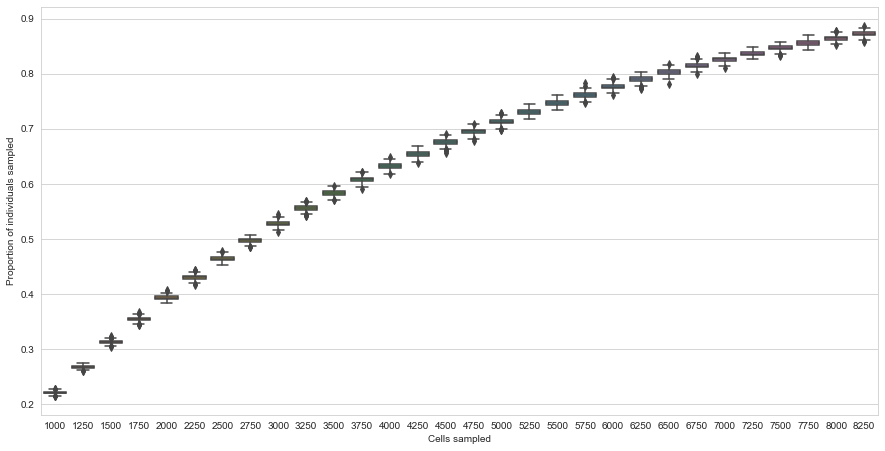

In [194]:
sim_plot(indivs=4000)

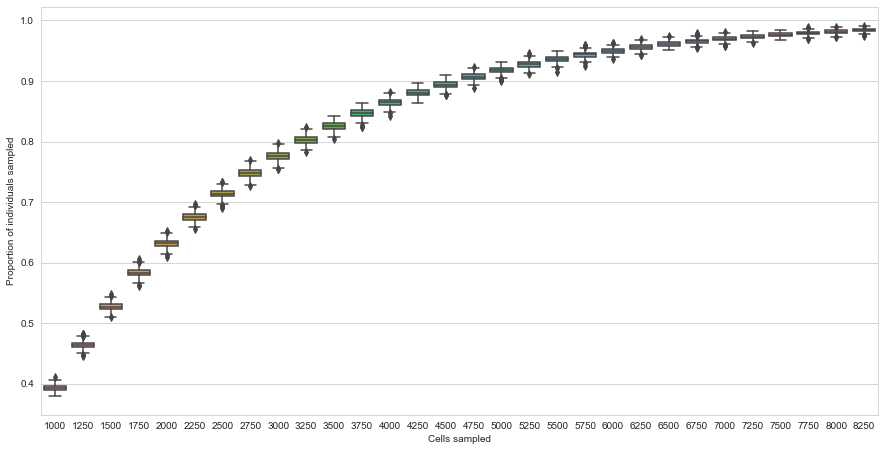

In [195]:
sim_plot()

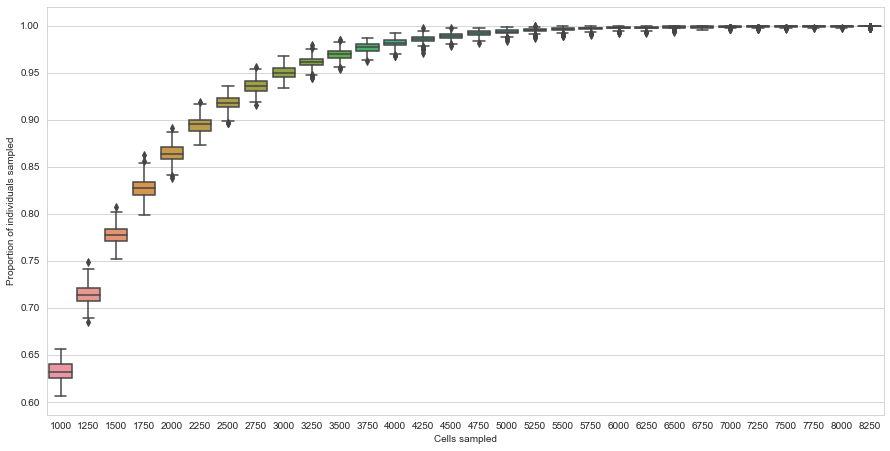

In [196]:
sim_plot(indivs=1000)

These simulations show a relationship that is predictable. The more cells you sample the closer you are to approximating the true distribution of individuals. It is also clear that in my previous simulation I was sampling 2,000 cells from 4,000 individuals I only was capturing 40% of the population. That is not particularly good if there is strong bias in size. I can try to capture this more explicitly by adding in a skew in the probability density for half of the individuals.

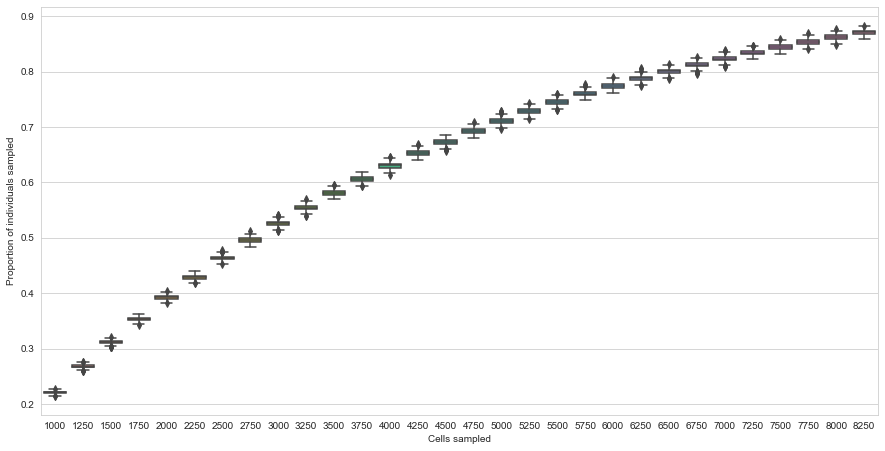

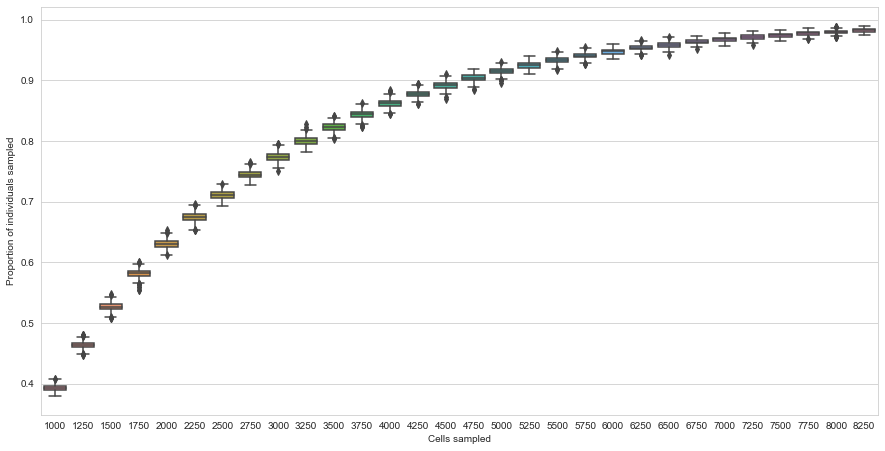

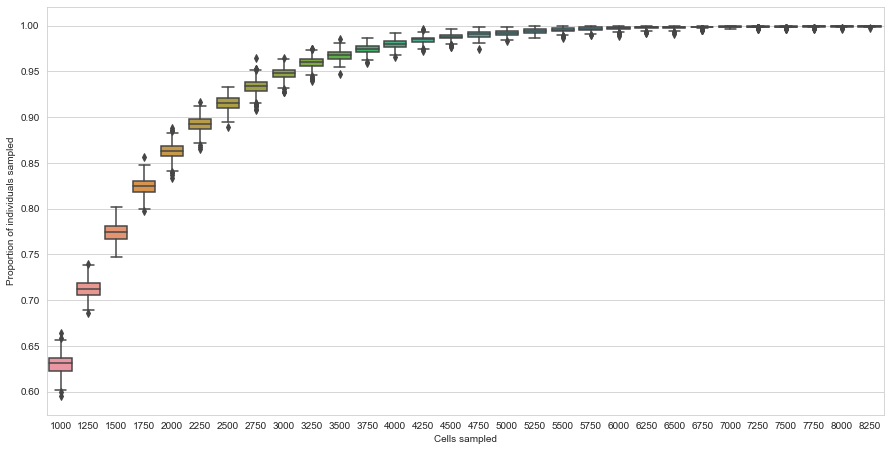

In [197]:
sim_plot(indivs=4000, skew=.05)

sim_plot(skew=.05)

sim_plot(indivs=1000, skew=.05)

Having mild skews in the probability distributions doesn't seem to really effect the underlying trends of this function so it might be a reasonable simplifying assumption to assume a uniform sampling probability when size differences are small. Therefore, I may just need to maximize the proportion of individuals sampled. But an important parameter to think about for this is the library prep cost and maximize the number of unique inidividuals.  


In [238]:
def opt_function(k, i):
    expect = (i * (1- ((i-1) / i)**k)) / k #expected proportion of unique individuals in sample
    prop = 1-math.exp(-k/i) #expected proportion of individuals sampled
    
    return expect, prop

In [283]:
def plot_optimize(I):
    e_i = []
    p_i = []
    for k_i in range(1, 14000, 500):
        e, p = opt_function(k=k_i, i=I)
        e_i.append(e)
        p_i.append(p)

    leg = ['Unique individuals', "Individuals sampled"]
    k_vector = [x for x in range(1, 14000, 500)]

    results = [e_i, p_i]
    fig = plt.figure(figsize=(10,5))
    with sns.axes_style('whitegrid'):
        for i in range(2):
            sns.lineplot(k_vector, results[i])
        plt.xlabel('Cells')
        plt.ylabel('Proportion')
        plt.legend(leg)
        plt.show()
        plt.close()

Here we have defined a function that takes cells and individuals as input and returns the expected proportion of unique individuals in the sample and the expected proportion of individuals sampled.

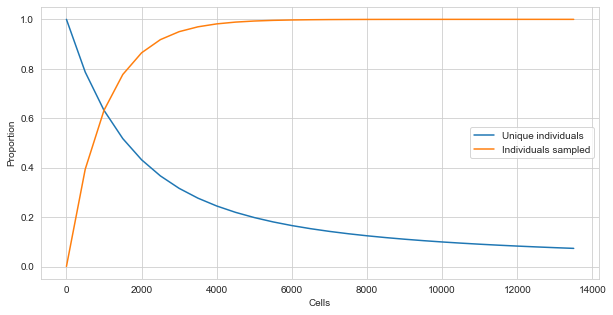

In [284]:
plot_optimize(I=1000)

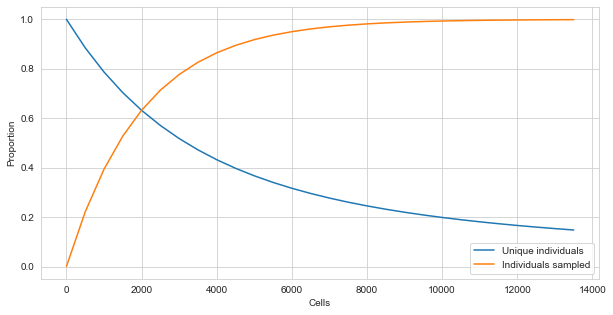

In [285]:
plot_optimize(I=2000)

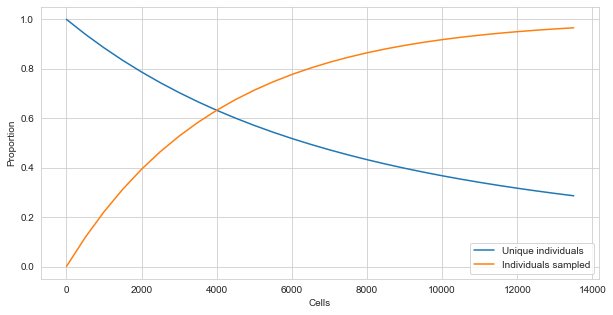

In [286]:
plot_optimize(I=4000)

My conclusion is that these two functions are essentially inverse of each other as would be expected. And there is some amount of maximization of both that can be made. However, it may be better to simply maximize the individuals sampled rather than unique individuals.